In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.getcwd()))
sys.path.append(root_dir)
results_dir = os.path.join(root_dir, 'results')
plots_dir = os.path.join(root_dir, 'plots')
if plots_dir is not None:
    os.makedirs(plots_dir, exist_ok=True)

In [2]:
import math
import numpy as np
from utils.data_utils import load_dataset, save_dataset
from datetime import timedelta
from utils.functions import get_durations, ensure_backward_compatibility, compute_dataset_costs

In [3]:
%matplotlib inline
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

# Helper functions

In [4]:
def get_result_statistics(results, opts, num_gpus=None, include_failed_instances_in_duration=False, as_percentage_of=None):

    ensure_backward_compatibility(opts)
    
    results_stat = [(cost, tour, duration) for (cost, tour, duration) in results if tour is not None]
    failed = [i for i, (cost, tour, duration) in enumerate(results) if tour is None]
    
    costs, tours, durations = zip(*results_stat)
    
    if include_failed_instances_in_duration:
        _, _, durations = zip(*results)
    
    avg_serial_duration, avg_parallel_duration, total_duration_parallel, total_duration_single_device, effective_batch_size = get_durations(
        durations, opts.batch_size, opts.system_info['used_num_processes'], opts.system_info['used_device_count']
    )
    
    # Adjust to reporting number of GPUs
    total_duration = total_duration_parallel if num_gpus is None else total_duration_single_device * num_gpus

    mean_cost = np.mean(costs)
    if as_percentage_of is not None:
        mean_cost = ((mean_cost / as_percentage_of) - 1) * 100
    
    return mean_cost, total_duration, len(results), failed

def get_baseline_result_statistics(results, num_cpus=None):
    
    results_stat = [res for res in results if res is not None]
    failed = [i for i, res in enumerate(results) if res is None]
    
    costs, tours, durations = zip(*results_stat)
    
    total_duration = np.sum(durations) / num_cpus
    return np.mean(costs), timedelta(seconds=int(total_duration+0.5)), len(results), failed

## Validate results

In [5]:
import torch
from problems import TSP, CVRP, TSPTW
from torch.utils.data import DataLoader
            
problem_dataset_lookup = {}
def get_problem_and_dataset(dataset_name):
    if dataset_name in problem_dataset_lookup:
        return problem_dataset_lookup[dataset_name]

    
    problem = CVRP if 'vrp' in dataset_name else (TSPTW if 'tsptw' in dataset_name else TSP)
    dataset_filepath = os.path.join(root_dir, 'data', 'vrp' if problem is CVRP else problem.NAME, dataset_name + '.pkl')
    kwargs = {} if problem is TSP else {'normalize': False}
    dataset = problem.make_dataset(filename=dataset_filepath, **kwargs)

    problem_dataset_lookup[dataset_name] = (problem, dataset)
    return (problem, dataset)
    
    
def check_costs(dataset_name, results, batch_size=1000, warn_only=False):
    problem, dataset = get_problem_and_dataset(dataset_name)
    costs, tours, durations = zip(*((None, None, None) if res is None else res for res in results))
    return compute_dataset_costs(problem, dataset, tours, check_costs=costs, batch_size=batch_size, warn_only=warn_only)


# Main results

In [6]:
size = 100

heatmap_names = {
    'tsp': {
        'tsp': f'heatmaps_tsp{size}',
    },
    'vrp': {
        'vrp_nazari': f'heatmaps_vrp_nazari{size}',
        'vrp_uchoa': f'heatmaps_vrp_uchoa{size}',
    },
    'tsptw': {
        'tsptw_capparti': f'heatmaps_tsptw{size}',
        'tsptw_da_silva': f'heatmaps_tsptwds{size}_dir'
    }
}

baselines = {
    'tsp': {
        'gnn_hm_bs': 7.87,
        'learning_2opt': 7.83,
        'merged_gnn': 7.764,  # Note: better than optimal, different dataset?
        'am_sampling': 7.94,
        'step_wise_am': 8.01,
        'learn_improv': 7.87,
        'pomo': 7.77,
    },
    'vrp_nazari': {
        'am_sampling': 16.23,
        'step_wise_am': 16.49,
        'learn_improv': 16.03,
        'pomo': 15.76,  # Slightly different than paper, ran their code on our test set
        'neurewriter': 16.10,
        'dynamic_am': 16.27,
        'nlns': 15.99,
        'l2i': 15.57,  # Note: good results but different data and trains per instance! Extremely slow
    },
    'tsptw_capparti': {  # All from Cappart et al.
        'bab_dqn': 5130.51,  # From personal communication with Quentin Cappart
        'ilds_dqn': 5130.45,
        'rbs_ppo': 5133.13,
    }
}

hm_durations = {k: {} for k in heatmap_names.keys()}

report_as_percentage = True

for problem, subproblems in heatmap_names.items():
    for subproblem, heatmap_name in subproblems.items():
        print(subproblem)
        beam_sizes = (10000, 100000, 1000000)
        
        seed = 1 if subproblem == 'tsptw_capparti' else 1234
        dataset_name = f'{subproblem}{size}_test_seed{seed}'
        dataset_dir = os.path.join(results_dir, problem, dataset_name)
        
        expected_num_instances = (100 if subproblem == 'tsptw_capparti' else 10000)
        
        if report_as_percentage:
            if problem == 'vrp':
                vrp_costs = {}
                vrp_durations = {}
                for method in ('hgs', 'lkh'):
                    # Compute baseline cost: hybrid genetic search
                    filename = os.path.join(dataset_dir, f'{subproblem}{size}_test_seed1234-{method}.pkl')

                    results, opts = load_dataset(filename)
                    assert results is not None

                    check_costs(dataset_name, results)

                    costs, duration, num_instances, failed = get_baseline_result_statistics(results, num_cpus=16)

                    if len(failed) > 0:
                        assert method == 'lkh'
                        total_cost_baseline = costs * (num_instances - len(failed))
                        # Get individual LKHU runs for failed instances
                        assert subproblem == 'vrp_uchoa'
                        for i in failed:
                            filename = os.path.join(dataset_dir, f'{subproblem}{size}_test_seed1234offs{i}n1-lkhu.pkl')
                            results, opts = load_dataset(filename)

                            failed_cost, failed_duration, failed_num_instances, failed_failed = get_baseline_result_statistics(results, num_cpus=16)
                            assert failed_num_instances == 1
                            assert len(failed_failed) == 0
                            total_cost_baseline += failed_cost

                        costs = total_cost_baseline / num_instances
                    vrp_costs[method] = costs
                    vrp_durations[method] = total_duration
                    
                    assert num_instances == expected_num_instances

                    print ("{:12}   {:.3f}   {:.3f}%   {}   {}".format(method, costs, (costs / vrp_costs['hgs'] - 1) * 100, duration, num_instances))
                mean_cost_baseline = vrp_costs['hgs']
            elif problem == 'tsptw':
                tsptw_costs = {}
                tsptw_durations = {}
                for method in ('gvns30', 'gvns', 'lkh'):
                    results, parallelism = load_dataset(os.path.join(
                        dataset_dir, 
                        f'{dataset_name}-{method}.pkl'
                    ))
                    
                    # We may have small differences due to rounding ; warn only if so
                    check_costs(dataset_name, results, warn_only=True)

                    costs, duration, num_instances, failed = get_baseline_result_statistics(results, num_cpus=16)
                    assert len(failed) == 0 or method == 'lkh'
                    assert num_instances == expected_num_instances

                    tsptw_costs[method] = costs
                    tsptw_durations[method] = duration
                    success_str = "failed: {:.2f}%".format((len(failed) / num_instances) * 100) if len(failed) > 0 else ''
                    print ("{:12s}   {:.3f}   {:.3f}%   {}   {} {}".format(method, costs, (costs / tsptw_costs['gvns30'] - 1) * 100, duration, num_instances, success_str))
                mean_cost_baseline = tsptw_costs['gvns30']
            else:
                tsp_costs = {}
                tsp_durations = {}
                for method in ('concorde', 'lkh', 'gurobigap1'):

                    results, parallelism = load_dataset(os.path.join(
                        dataset_dir, 
                        f'{dataset_name}-{method}.pkl'
                    ))

                    check_costs(dataset_name, results)

                    costs, duration, num_instances, failed = get_baseline_result_statistics(results, num_cpus=16)
                    assert len(failed) == 0
                    assert num_instances == expected_num_instances

                    tsp_costs[method] = costs
                    tsp_durations[method] = duration
                    print ("{:12s}   {:.3f}   {:.3f}%   {}   {}".format(method, costs, (costs / tsp_costs['concorde'] - 1) * 100, duration, num_instances))
                mean_cost_baseline = tsp_costs['concorde']


            # Load heatmaps
            if subproblem not in hm_durations[problem]:    

                heatmaps, hm_extra = load_dataset(os.path.join(
                    dataset_dir, 
                    'heatmaps', heatmap_name
                ))
                
                hm_durations[problem][subproblem] = (timedelta(seconds=hm_extra['duration'] * hm_extra['device_count']), len(heatmaps))
                heatmaps = None

            # Load results
            for method in ('dpdp', ) if problem != 'tsptw' else ('dpdp', 'dpdp-'):
                print(method)
                for beam_size in beam_sizes:
                    filename = os.path.join(dataset_dir, 'main_results', f'beam{beam_size}dpdp-.pkl' if method == 'dpdp-' else f'beam{beam_size}.pkl')
                    if not os.path.isfile(filename):
                        print("WARNING: missing", method, "beam size", beam_size)
                        continue

                    results, opts = load_dataset(filename)

                    costs = check_costs(dataset_name, results)

                    mean_cost, total_duration, num_instances, failed = get_result_statistics(results, opts, num_gpus=1)
                    assert len(failed) == 0 or method == 'dpdp-'
                    assert num_instances == expected_num_instances
                    success_str = "failed: {:.2f}%".format((len(failed) / num_instances) * 100) if len(failed) > 0 else ''
                    print ("{:12}   {:.3f}   {:.3f}%   {}   {} {}".format(beam_size, mean_cost, (mean_cost / mean_cost_baseline - 1) * 100, total_duration, num_instances, success_str))
        
        for k, v in baselines.get(subproblem, {}).items():
            print ("{:12}   {:.2f}   {:.2f}%".format(k, v, (v / mean_cost_baseline - 1) * 100))
            
        
        print()
hm_durations

tsp
concorde       7.765   0.000%   0:06:09   10000
lkh            7.765   0.000%   0:41:58   10000
gurobigap1     7.776   0.151%   0:31:18   10000
dpdp
       10000   7.765   0.009%   0:15:32   10000 
      100000   7.765   0.004%   2:34:54   10000 
gnn_hm_bs      7.87   1.36%
learning_2opt   7.83   0.84%
merged_gnn     7.76   -0.01%
am_sampling    7.94   2.26%
step_wise_am   8.01   3.16%
learn_improv   7.87   1.36%
pomo           7.77   0.07%

vrp_nazari
hgs            15.563   0.000%   6:10:57   10000
lkh            15.647   0.536%   12:57:22   10000
dpdp
       10000   15.830   1.713%   0:49:59   10000 
      100000   15.694   0.843%   5:48:27   10000 
     1000000   15.627   0.409%   2 days, 0:27:36   10000 
am_sampling    16.23   4.28%
step_wise_am   16.49   5.96%
learn_improv   16.03   3.00%
pomo           15.76   1.26%
neurewriter    16.10   3.45%
dynamic_am     16.27   4.54%
nlns           15.99   2.74%
l2i            15.57   0.04%

vrp_uchoa
hgs            18049.509   0.000% 

{'tsp': {'tsp': (datetime.timedelta(seconds=582, microseconds=925191), 10000)},
 'vrp': {'vrp_nazari': (datetime.timedelta(seconds=606, microseconds=522016),
   10000),
  'vrp_uchoa': (datetime.timedelta(seconds=312, microseconds=184925), 10000)},
 'tsptw': {'tsptw_capparti': (datetime.timedelta(seconds=48, microseconds=699034),
   100),
  'tsptw_da_silva': (datetime.timedelta(seconds=279, microseconds=122417),
   10000)}}

# Ablations

In [7]:
report_as_percentage = True

problem = 'vrp'
subproblem = 'vrp_nazari'
dataset_name = f'{subproblem}{size}_validation_seed4321'
dataset_dir = os.path.join(results_dir, problem, dataset_name)

if report_as_percentage:
    # Compute baseline cost: HGS
    filename = os.path.join(dataset_dir, f'{dataset_name}-hgs.pkl')
    results, opts = load_dataset(filename)
    
    mean_cost_baseline, *_ = get_baseline_result_statistics(results[:100], num_cpus=32)
else:
    mean_cost_baseline = None

hm_dur, hm_count = hm_durations[problem][subproblem]
hm_avg_secs = hm_dur.seconds / hm_count
check_num_instances = 100

dataset_dir = os.path.join(results_dir, problem, dataset_name)

## Adjacency experiments

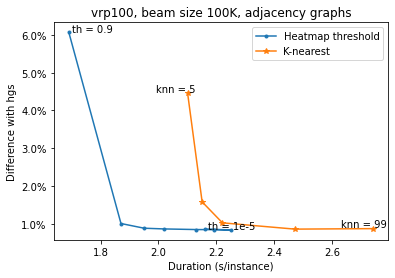

In [8]:
heatmap_thresholds = ('1e-5', '1e-4', '1e-3', '1e-2', '0.1', '0.2', '0.5', '0.9')

th_results = []
for th in heatmap_thresholds:
    results, opts = load_dataset(os.path.join(dataset_dir, 'adj_experiment', f'heatmapth{th}.pkl'))

    mean_cost, total_duration, num_instances, failed = get_result_statistics(results, opts, num_gpus=1, as_percentage_of=mean_cost_baseline)
    assert check_num_instances == num_instances

    if len(failed) != 0:
        print('Warning: failed', failed, 'instances for th', th)
        continue

    th_results.append((th, mean_cost, total_duration))

knn_results = []
heatmap_knns = (5, 10, 20, 50, 99)
for knn in heatmap_knns:
    results, opts = load_dataset(os.path.join(dataset_dir, 'adj_experiment', f'knn{knn}.pkl'))

    mean_cost, total_duration, num_instances, failed = get_result_statistics(results, opts, num_gpus=1, as_percentage_of=mean_cost_baseline)
    assert check_num_instances == num_instances

    if len(failed) != 0:
        print('Warning: failed', failed, 'instances for knn', knn)
        continue

    knn_results.append((knn, mean_cost, total_duration))

results, opts = load_dataset(os.path.join(dataset_dir, 'adj_experiment', f'full.pkl'))

mean_cost, total_duration, num_instances, failed = get_result_statistics(results, opts, num_gpus=1, as_percentage_of=mean_cost_baseline)
assert check_num_instances == num_instances
assert len(failed) == 0

## Actual plotting

th_vals, th_costs, th_durs = zip(*th_results)

knn_vals, knn_costs, knn_durs = zip(*knn_results)

plt.figure()

plot_th_durs = [hm_avg_secs + th.seconds / num_instances for th in th_durs]
plot_knn_durs = [hm_avg_secs + th.seconds / num_instances for th in knn_durs]
plt.plot(plot_th_durs, th_costs, marker='.', label='Heatmap threshold')
plt.plot(plot_knn_durs, knn_costs, marker='*', label='K-nearest')

if report_as_percentage:
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

plt.legend()
plt.xlabel('Duration (s/instance)')
plt.ylabel('Difference with hgs' if report_as_percentage else 'Cost')

plt.title(f'{problem}100, beam size 100K, adjacency graphs')

if problem == 'vrp':
    plt.annotate('th = ' + th_vals[0], (plot_th_durs[0] + 0.01, th_costs[0]))
    plt.annotate('th = ' + th_vals[-1], (plot_th_durs[-1] + 0.01, th_costs[-1]))
    plt.annotate('knn = ' + str(knn_vals[0]), (plot_knn_durs[0] - 0.11, knn_costs[0] + 0.03))
    plt.annotate('knn = ' + str(knn_vals[-1]), (plot_knn_durs[-1] - 0.11, knn_costs[-1] + 0.03))
else:
    plt.annotate('th = ' + th_vals[0], (plot_th_durs[0] + 0.01, th_costs[0] - 3.8e-5))
    plt.annotate('th = ' + th_vals[-1], (plot_th_durs[-1] + 0.01, th_costs[-1]))
    plt.annotate('knn = ' + str(knn_vals[0]), (plot_knn_durs[0] - 0.08, knn_costs[0] + 2e-5))
    plt.annotate('knn = ' + str(knn_vals[-1]), (plot_knn_durs[-1] - 0.11, knn_costs[-1] + 2e-5))

if plots_dir is not None:
    plt.savefig(os.path.join(plots_dir, 'vrp_adjacency.pdf'), bbox_inches='tight')
plt.show()


# Score function experiments

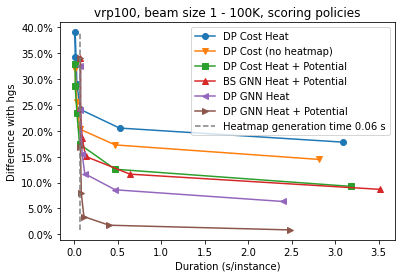

In [11]:
markers = ['o', 'v', 's', '^', '<', '>']

score_functions = ('costheatmap', 'cost', 'costheatmap_potential', 'dpbs_heatmap_potential', 'heatmap', 'heatmap_potential')
labels = ('DP Cost Heat', 'DP Cost (no heatmap)', 'DP Cost Heat + Potential', 'BS GNN Heat + Potential', 'DP GNN Heat', 'DP GNN Heat + Potential')
beam_sizes = (1, 10, 100, 1000, 10000, 100000)

plt.figure()    

all_sf_results = {}
all_min_costs = math.inf
all_max_costs = -math.inf
for score_function, marker, label in zip(score_functions, markers, labels):
    sf_results = []
    for beam_size in beam_sizes:

        results, opts = load_dataset(os.path.join(dataset_dir, 'score_function_experiment', f'beam{beam_size}_{score_function}.pkl'))

        mean_cost, total_duration, num_instances, failed = get_result_statistics(results, opts, num_gpus=1, as_percentage_of=mean_cost_baseline)
        assert check_num_instances == num_instances

        if len(failed) != 0:
            print('Warning: failed', failed, 'instances for th', th)
            continue
            
        costs, tours, durations = zip(*results)
        sf_results.append((beam_size, mean_cost, total_duration))

    bszs, costs, durs = zip(*sf_results)
    # Don't add heatmap generation time for cost(based) score function
    plot_durs = [(0 if score_function[:4] == 'cost' else hm_avg_secs) + th.seconds / num_instances for th in durs]
    plt.plot(plot_durs, costs, marker=marker, label=label)
    all_sf_results[score_function] = sf_results

    all_min_costs = min(min(costs), all_min_costs)
    all_max_costs = max(max(costs), all_max_costs)

if hm_avg_secs > 0:
    plt.plot([hm_avg_secs, hm_avg_secs], [all_min_costs, all_max_costs], color='grey', linestyle='--', label='Heatmap generation time {:.2f} s'.format(hm_avg_secs))

if report_as_percentage:
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

plt.legend()
plt.xlabel('Duration (s/instance)')
plt.ylabel('Difference with hgs' if report_as_percentage else 'Cost')
plt.title(f'{problem}100, beam size 1 - 100K, scoring policies')
plt.savefig('plots/vrp_scoring_policy.pdf', bbox_inches='tight')
plt.show()


# Beam size experiments

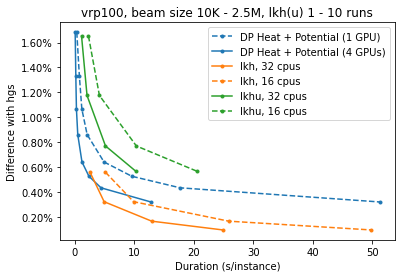

In [10]:
import matplotlib.ticker as mtick

markers = ['v', '^', '<', '>']

beam_sizes = (10000, 25000, 50000, 100000, 250000, 500000, 1000000, 2500000)
check_num_instances = 100

plt.figure()
ax = plt.gca()

bz_results = []
for beam_size in beam_sizes:

    if not os.path.isfile(os.path.join(dataset_dir, 'beam_size_experiment', f'beam{beam_size}.pkl')):
        print('Missing beam size', beam_size)
        continue
    results, opts = load_dataset(os.path.join(dataset_dir, 'beam_size_experiment', f'beam{beam_size}.pkl'))

    mean_cost, total_duration, num_instances, failed = get_result_statistics(results, opts, num_gpus=1, as_percentage_of=mean_cost_baseline)
    assert check_num_instances == num_instances

    if len(failed) != 0:
        print('Warning: failed', failed, 'instances for th', th)
        continue

    bz_results.append((beam_size, mean_cost, total_duration))
bszs, costs, durs = zip(*bz_results)

plot_durs = [hm_avg_secs + th.seconds / num_instances for th in durs]

color = next(ax._get_lines.prop_cycler)['color']

plt.plot(plot_durs, costs, marker='.', label='DP Heat + Potential (1 GPU)', linestyle='--', color=color)        
plt.plot(np.array(plot_durs) / 4, costs, marker='.', label='DP Heat + Potential (4 GPUs)', color=color)

lkh_runs = (1, 2, 5, 10)

for lkh_variant in ('lkh', 'lkhu'):

    run_results = []
    for runs in lkh_runs:
        filename = os.path.join(dataset_dir, f'{dataset_name}n100-{lkh_variant}{runs if runs > 1 else ""}.pkl')
        if not os.path.isfile(filename):
            print(f"Warning: skipping {runs} runs for {lkh_variant}")
            continue
        results, opts = load_dataset(filename)

        mean_cost, total_duration, num_instances, failed = get_baseline_result_statistics(results, num_cpus=32)
        assert check_num_instances == num_instances
        
        if report_as_percentage:
            mean_cost = ((mean_cost / mean_cost_baseline) - 1) * 100
        
        run_results.append((runs, mean_cost, total_duration))

    runs, costs, durs = zip(*run_results)

    plot_durs = [th.seconds / num_instances for th in durs]
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(plot_durs, costs, marker='.', label=f'{lkh_variant}, 32 cpus', color=color)
    plt.plot(np.array(plot_durs) * 2, costs, marker='.', label=f'{lkh_variant}, 16 cpus', linestyle='--', color=color)

if report_as_percentage:
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

plt.legend()
plt.xlabel('Duration (s/instance)')
plt.ylabel('Difference with hgs' if report_as_percentage else 'Cost')
if subproblem == 'vrp_nazari':
    plt.title(f'vrp100, beam size 10K - 2.5M, lkh(u) 1 - 10 runs')
else:
    plt.title(f'{subproblem}100, beam size 10K - 2.5M, lkh(u) 1 - 10 runs')
plt.savefig(f'plots/{subproblem}_beam_sizes.pdf', bbox_inches='tight')
plt.show()
